In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from collections import deque
from SnakeEnv import SnakeEnvironment

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class Net(nn.Module):

    def __init__(self, learning_rate=0.01):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(state_size, 12)  
        self.fc2 = nn.Linear(12, 24)
        self.fc3 = nn.Linear(24, action_size)
        self.optim  = torch.optim.Adam(self.parameters(), lr=learning_rate)
        self.loss = torch.nn.MSELoss()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self, x):
        #print(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x),dim=0)
        #print(x[0][0].item())
        return x


In [3]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.max_memory = 2000 
        self.state_memory = np.zeros((self.max_memory,self.state_size))
        self.action_memory = np.zeros((self.max_memory,1))
        self.reward_memory = np.zeros((self.max_memory,1))
        self.next_state_memory = np.zeros((self.max_memory,self.state_size))
        self.done_memory = np.zeros((self.max_memory,1))
        self.memory_size = 0 #current size of memory
        self.dueling_type = 'avg'

        # Hyperparameters
        self.gamma = 0.99    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.99
        self.learning_rate = 0.001
        self.DQN = Net(self.learning_rate)
        self.target_network = Net(self.learning_rate)
        self.target_network.load_state_dict(self.DQN.state_dict())

    def remember(self, state, action, reward, next_state, done):
        index = self.memory_size%self.max_memory
        if self.memory_size < self.max_memory:
            self.state_memory[self.memory_size] = state
            self.action_memory[self.memory_size] = action
            self.reward_memory[self.memory_size] = reward
            self.next_state_memory[self.memory_size] = next_state
            self.done_memory[self.memory_size] = done
            self.memory_size += 1
        else:
            self.state_memory[index] = state
            self.action_memory[index] = action
            self.reward_memory[index] = reward
            self.next_state_memory[index] = next_state
            self.done_memory[index] = done


    def act(self, state):
        #np.random.seed(0)
        #torch.manual_seed(0)
        #random.seed(30)
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)

        act_values = self.DQN.forward(torch.tensor(state,device = self.DQN.device,dtype=torch.float32))
        return torch.argmax(act_values).item()  # returns action

    def replay(self, batch_size):
        self.DQN.optim.zero_grad()

        batch = np.random.choice(self.memory_size,batch_size)
            
        state_batch = torch.tensor(self.state_memory[batch],device = self.DQN.device,dtype=torch.float32)
        action_batch = torch.tensor(self.action_memory[batch],device = self.DQN.device, dtype=torch.uint8)
        reward_batch = torch.tensor(self.reward_memory[batch],device = self.DQN.device,dtype=torch.uint8)
        next_state_batch = torch.tensor(self.next_state_memory[batch],device = self.DQN.device,dtype=torch.float32)
        done_batch = torch.tensor(self.done_memory[batch],device = self.DQN.device,dtype=torch.uint8)

        Q_value = self.DQN.forward(state_batch).to(self.DQN.device)
        Q_target = Q_value.clone()
        Q_next = self.target_network.forward(next_state_batch).to(self.DQN.device)
        
        batch_index = np.arange(batch_size,dtype=np.int32)
        Q_target[batch_index,action_batch.cpu().numpy()] = reward_batch.float() + self.gamma + torch.max(Q_next, dim=1)[0]*done_batch.float()
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        loss = self.DQN.loss(Q_target, Q_value).to(self.DQN.device)
        loss.backward()
        self.DQN.optim.step()


    def load(self, PATH):
        self.DQN.load_state_dict(torch.load(PATH))
        self.DQN.eval()
        

    def save(self, PATH):
        torch.save(self.DQN.state_dict(), PATH)

    #Fixed Q targets
    def update_target_weights(self):
        self.target_network.load_state_dict(self.DQN.state_dict())


In [12]:
EPOCHS = 200
EPISODES = 100
DURATION = 500
SS = 20
tau = 100

EPOCH:  0
EPOCH:  1
EPOCH:  2
EPOCH:  3
EPOCH:  4
EPOCH:  5
EPOCH:  6
EPOCH:  7
EPOCH:  8
EPOCH:  9
EPOCH:  10
EPOCH:  11
EPOCH:  12
EPOCH:  13
EPOCH:  14
EPOCH:  15
EPOCH:  16
EPOCH:  17
EPOCH:  18
EPOCH:  19
EPOCH:  20
EPOCH:  21
EPOCH:  22
EPOCH:  23
EPOCH:  24
EPOCH:  25
EPOCH:  26
EPOCH:  27
EPOCH:  28
EPOCH:  29
EPOCH:  30
EPOCH:  31
EPOCH:  32
EPOCH:  33
EPOCH:  34
EPOCH:  35
EPOCH:  36
EPOCH:  37
EPOCH:  38
EPOCH:  39
EPOCH:  40
EPOCH:  41
EPOCH:  42
EPOCH:  43
EPOCH:  44
EPOCH:  45
EPOCH:  46
EPOCH:  47
EPOCH:  48
EPOCH:  49
EPOCH:  50
EPOCH:  51
EPOCH:  52
EPOCH:  53
EPOCH:  54
EPOCH:  55
EPOCH:  56
EPOCH:  57
EPOCH:  58
EPOCH:  59
EPOCH:  60
EPOCH:  61
EPOCH:  62
EPOCH:  63
EPOCH:  64
EPOCH:  65
EPOCH:  66
EPOCH:  67
EPOCH:  68
EPOCH:  69
EPOCH:  70
EPOCH:  71
EPOCH:  72
EPOCH:  73
EPOCH:  74
EPOCH:  75
EPOCH:  76
EPOCH:  77
EPOCH:  78
EPOCH:  79
EPOCH:  80
EPOCH:  81
EPOCH:  82
EPOCH:  83
EPOCH:  84
EPOCH:  85
EPOCH:  86
EPOCH:  87
EPOCH:  88
EPOCH:  89
EPOCH:  90
EPOCH:  9

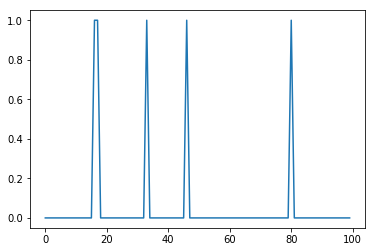

In [13]:
for epoch in range(EPOCHS):
    # Initialise environment
    print('EPOCH: ', epoch)
    render = False
    env = SnakeEnvironment(screenSize = SS,render = render)
    state_size = len(env.state)
    action_size = len(env.actions)
    memory = deque(maxlen=2000)
    agent = DQNAgent(state_size, action_size)
    agent.load("snake-v4-dqn.pt")
    batch_size = 30
    scores=[]
    for e in range(EPISODES):
        env = SnakeEnvironment(screenSize = SS, render=render)
        state = env.state
        state = np.reshape(state, [1, state_size])
        apples_collected = 0
        for time in range(DURATION+1):
            action = agent.act(state)
            next_state, reward, done, apple = env.step(action)
            apples_collected += apple
            next_state = np.reshape(next_state, [1, state_size])
            if time == DURATION:
                reward += 10
            if reward != 0:
                agent.remember(state, action, reward, next_state, done)
            state = next_state
            if done or time == DURATION:
                #print("episode: {}/{}, score: {}, e: {:.2}".format(e, EPISODES, apples_collected, agent.epsilon))
                scores.append(env.totalReward)
                break
            if time % tau == 0:
                agent.update_target_weights()
                

                if agent.memory_size > batch_size:
                    agent.replay(batch_size)

        if e % 10 == 0:
            agent.save("snake-v4-dqn.pt")


plt.plot(range(len(scores)),scores)
plt.show()